# ASL Word Training — Kaggle GPU Optimized (WLASL + MediaPipe + BiLSTM)

**Full-parameter Kaggle notebook** for training a word-level ASL recognition model using WLASL videos.

### Key Features:

- **Two-hand detection** (126 features = 2 × 21 landmarks × 3 coords) — captures signs requiring both hands
- **GPU-optimized** for Kaggle T4/P100 GPUs
- **Full training parameters** — no shortcuts, full augmentation pipeline
- **Mixed Precision (float16)** — faster training on modern GPUs
- **tf.data pipeline** with prefetch, shuffle & augmentation
- **CuDNN-compatible LSTM** — hardware-accelerated RNN
- **Temporal Attention** — learns which frames matter most
- **Label smoothing + gradient clipping** — robust training
- **Comprehensive evaluation** — confusion matrix, per-class F1, category breakdown

### Output Artifacts:

- `asl_word_sequences_2hand.npz` — Extracted two-hand sequences
- `asl_word_lstm_model_best.h5` — Best model checkpoint
- `asl_word_lstm_model_final.h5` — Final model
- `asl_word_classes.csv` — Class mapping

### Kaggle Setup:

1. Upload `shared_word_vocabulary.csv`, `WLASL_v0.3.json`, `nslt_2000.json`, `missing.txt` as a dataset
2. Upload WLASL videos folder as a dataset
3. Enable GPU accelerator in notebook settings
4. Run all cells in order


In [16]:
# ===============================
# CELL 1: INSTALL & IMPORTS
# ===============================
# Force install the stable MediaPipe version right at the top
!pip install mediapipe==0.10.13 -q

import json
import os
import time
from pathlib import Path

import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import mixed_precision
from tqdm import tqdm

print('=' * 60)
print('✅ All libraries imported successfully')
print(f'📦 TensorFlow : {tf.__version__}')
print(f'📦 MediaPipe  : {mp.__version__}')
print('=' * 60)

✅ All libraries imported successfully
📦 TensorFlow : 2.19.0
📦 MediaPipe  : 0.10.13


In [17]:
# ============================================
# CELL 2: GPU DETECTION & CONFIGURATION
# ============================================
print('=' * 60)
print('🔍 GPU DETECTION & CONFIGURATION')
print('=' * 60)
print(f'\nTensorFlow version: {tf.__version__}')
print(f'Built with CUDA  : {tf.test.is_built_with_cuda()}')

physical_devices = tf.config.list_physical_devices()
print(f'\nAll Physical Devices: {physical_devices}')

gpus = tf.config.list_physical_devices('GPU')
print(f'\n🎮 GPU Devices Found: {len(gpus)}')

USE_GPU = False
DEVICE = '/CPU:0'

if gpus:
    print('\n✅ GPU IS AVAILABLE!')
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f'   ✅ Memory growth enabled for {len(gpus)} GPU(s)')

        tf.config.set_visible_devices(gpus[0], 'GPU')
        USE_GPU = True
        DEVICE = '/GPU:0'
        print(f'   ✅ Using GPU: {gpus[0].name}')

        try:
            details = tf.config.experimental.get_device_details(gpus[0])
            if 'device_name' in details:
                print(f'   📊 Device Name       : {details["device_name"]}')
            if 'compute_capability' in details:
                print(f'   📊 Compute Capability: {details["compute_capability"]}')
        except Exception:
            pass

    except RuntimeError as e:
        print(f'   ⚠️  GPU config error: {e}')
else:
    print('\n⚠️  No GPU detected — training on CPU (will be much slower)')

# Mixed precision — keep OFF for LSTM to avoid NaN
ENABLE_MIXED_PRECISION = False

if USE_GPU and ENABLE_MIXED_PRECISION:
    try:
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
        print(f'\n⚡ Mixed precision enabled: {policy.name}')
    except Exception as e:
        print(f'\n⚠️  Mixed precision not enabled: {e}')
else:
    mixed_precision.set_global_policy('float32')
    print(f'\n📐 Using float32 precision (stable for LSTM)')

# GPU verification test
if USE_GPU:
    print('\n🧪 GPU Verification Test...')
    try:
        with tf.device('/GPU:0'):
            a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
            b = tf.constant([[5.0, 6.0], [7.0, 8.0]])
            c = tf.matmul(a, b)
        print(f'   ✅ GPU computation successful: {c.device}')
    except Exception as e:
        print(f'   ❌ GPU test failed: {e}')
        USE_GPU = False
        DEVICE = '/CPU:0'

print(f'\n✅ Configuration complete. Using device: {DEVICE}')
print('=' * 60)


🔍 GPU DETECTION & CONFIGURATION

TensorFlow version: 2.19.0
Built with CUDA  : True

All Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

🎮 GPU Devices Found: 1

✅ GPU IS AVAILABLE!
   ✅ Memory growth enabled for 1 GPU(s)
   ✅ Using GPU: /physical_device:GPU:0
   📊 Device Name       : Tesla P100-PCIE-16GB
   📊 Compute Capability: (6, 0)

📐 Using float32 precision (stable for LSTM)

🧪 GPU Verification Test...
   ✅ GPU computation successful: /job:localhost/replica:0/task:0/device:GPU:0

✅ Configuration complete. Using device: /GPU:0


In [18]:
# ===============================
# CELL 3: CONFIGURATION / PATHS (ULTIMATE AUTO-SEARCH)
# ===============================
import os
from pathlib import Path

IS_KAGGLE = os.path.exists('/kaggle/input')

if IS_KAGGLE:
    print("🔍 Scanning Kaggle for your files...")
    KAGGLE_INPUT = Path('/kaggle/input')
    OUTPUT_DIR = Path('/kaggle/working')
    
    # Automatically hunt down the exact file paths without guessing folder names!
    try:
        SHARED_CSV = next(KAGGLE_INPUT.rglob('shared_word_vocabulary.csv'))
        WLASL_JSON = next(KAGGLE_INPUT.rglob('WLASL_v0.3.json'))
        NSLT_SPLIT = next(KAGGLE_INPUT.rglob('nslt_2000.json'))
        MISSING_TXT = next(KAGGLE_INPUT.rglob('missing.txt'))
        
        # Find the videos folder specifically
        video_folders = [p for p in KAGGLE_INPUT.rglob('videos') if p.is_dir()]
        VIDEO_DIR = video_folders[0] if video_folders else None
        
    except StopIteration:
        print("❌ ERROR: Could not find one or more files! Did you attach the dataset?")
        SHARED_CSV = WLASL_JSON = NSLT_SPLIT = MISSING_TXT = VIDEO_DIR = None

else:
    # ===== LOCAL PATHS (Ignored when running on Kaggle) =====
    PROJECT_ROOT = Path(r'D:\My_Graduation_Project')
    SHARED_CSV = PROJECT_ROOT / 'shared_word_vocabulary.csv'
    WLASL_JSON = PROJECT_ROOT / 'WLASL_v0.3.json'
    NSLT_SPLIT = PROJECT_ROOT / 'nslt_2000.json'
    MISSING_TXT = PROJECT_ROOT / 'missing.txt'
    VIDEO_DIR = PROJECT_ROOT / 'videos'
    OUTPUT_DIR = PROJECT_ROOT / 'ASL_Word_Output'

# ===== FULL TRAINING HYPERPARAMETERS =====
SEQUENCE_LENGTH = 30        
NUM_HANDS = 2               
LANDMARKS_PER_HAND = 63     
NUM_FEATURES = NUM_HANDS * LANDMARKS_PER_HAND  

BATCH_SIZE      = 64        
EPOCHS          = 200       
LEARNING_RATE   = 5e-4      
LSTM_UNITS_1    = 512       
LSTM_UNITS_2    = 256       
LSTM_UNITS_3    = 128       
DENSE_UNITS     = 512       
DROPOUT_RATE    = 0.5       
LABEL_SMOOTH    = 0.1       
GRAD_CLIP_NORM  = 1.0       
L2_REG          = 1e-4      
TEST_SIZE       = 0.3       

OUTPUT_DIR.mkdir(parents=True, exist_ok=True) if not IS_KAGGLE else None

# Verify paths
print("\n--- PATH VERIFICATION ---")
for name, path in [('Shared CSV', SHARED_CSV), ('WLASL JSON', WLASL_JSON),
                    ('NSLT Split', NSLT_SPLIT), ('Missing TXT', MISSING_TXT)]:
    status = '✅' if path and path.exists() else '❌ NOT FOUND'
    print(f'{status} {name}: {path}')

print(f'{"✅" if VIDEO_DIR and VIDEO_DIR.exists() else "❌ NOT FOUND"} Video dir : {VIDEO_DIR}')
print(f'📁 Output dir: {OUTPUT_DIR}')
print("-------------------------\n")

🔍 Scanning Kaggle for your files...

--- PATH VERIFICATION ---
✅ Shared CSV: /kaggle/input/datasets/ahmed171102/shared-english-and-arabic-dataset/shared_word_vocabulary.csv
✅ WLASL JSON: /kaggle/input/datasets/risangbaskoro/wlasl-processed/WLASL_v0.3.json
✅ NSLT Split: /kaggle/input/datasets/risangbaskoro/wlasl-processed/nslt_2000.json
✅ Missing TXT: /kaggle/input/datasets/risangbaskoro/wlasl-processed/missing.txt
✅ Video dir : /kaggle/input/datasets/risangbaskoro/wlasl-processed/videos
📁 Output dir: /kaggle/working
-------------------------



In [19]:
# ===============================
# CELL 4: LOAD VOCAB + WLASL METADATA
# ===============================

vocab_df = pd.read_csv(SHARED_CSV)
vocab_df = vocab_df.dropna(subset=['wlasl_class'])
vocab_df['wlasl_class'] = vocab_df['wlasl_class'].astype(int)

matched_wlasl_classes = set(vocab_df['wlasl_class'].tolist())
wlasl_to_wordid = dict(zip(vocab_df['wlasl_class'], vocab_df['word_id']))
id_to_english = dict(zip(vocab_df['word_id'].astype(int), vocab_df['english']))

with open(NSLT_SPLIT, 'r', encoding='utf-8') as f:
    nslt = json.load(f)

with open(MISSING_TXT, 'r', encoding='utf-8') as f:
    missing_ids = set(x.strip() for x in f if x.strip())

with open(WLASL_JSON, 'r', encoding='utf-8') as f:
    wlasl_data = json.load(f)

# Build download list filtered by shared vocabulary
download_list = []
for entry in wlasl_data:
    gloss = entry.get('gloss', '')
    for inst in entry.get('instances', []):
        vid = inst.get('video_id')
        if not vid or vid not in nslt or vid in missing_ids:
            continue
        class_id = int(nslt[vid]['action'][0])
        if class_id not in matched_wlasl_classes:
            continue
        download_list.append({
            'video_id': vid,
            'url': inst.get('url'),
            'class_id': class_id,
            'word_id': int(wlasl_to_wordid[class_id]),
            'gloss': gloss,
            'subset': nslt[vid]['subset']
        })

print(f'📥 Total video candidates: {len(download_list)}')
print(f'🏷️ Unique matched classes: {len(set(d["class_id"] for d in download_list))}')
print(f'📖 Vocabulary size: {len(vocab_df)} words')
print(f'\n📋 Categories: {sorted(vocab_df["category"].unique())}')


📥 Total video candidates: 1085
🏷️ Unique matched classes: 157
📖 Vocabulary size: 157 words

📋 Categories: ['adjective', 'direction', 'family', 'health', 'job', 'object', 'religion', 'social', 'verb']


In [20]:
# ===============================
# CELL 5: EXTRACT TWO-HAND MEDIAPIPE SEQUENCES
# ===============================
# Extracts BOTH hand landmarks from each video frame.
# Hands are consistently ordered: Left first, Right second.
# If only one hand is detected, the other is zero-padded.
# Skip this cell if the .npz file already exists!

NPZ_PATH = OUTPUT_DIR / 'asl_word_sequences_2hand.npz'

if NPZ_PATH.exists():
    print(f'⏩ Dataset already exists, skipping extraction')
    data = np.load(NPZ_PATH)
    X, y = data['X'], data['y']
    print(f'   X: {X.shape}, y: {y.shape}, classes: {len(np.unique(y))}')
else:
    mp_hands = mp.solutions.hands
    hands_detector = mp_hands.Hands(
        static_image_mode=False,
        max_num_hands=2,           # detect BOTH hands
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    )

    def extract_frame_landmarks_2hand(frame):
        """Extract landmarks for both hands from a single frame.
        Returns array of shape (126,) = [left_hand(63) | right_hand(63)].
        Hands are ordered by MediaPipe handedness label for consistency."""
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands_detector.process(rgb)

        left_vec = np.zeros(LANDMARKS_PER_HAND, dtype=np.float32)
        right_vec = np.zeros(LANDMARKS_PER_HAND, dtype=np.float32)

        if results.multi_hand_landmarks and results.multi_handedness:
            for hand_lm, handedness in zip(results.multi_hand_landmarks, results.multi_handedness):
                label = handedness.classification[0].label  # 'Left' or 'Right'
                vec = np.array([[p.x, p.y, p.z] for p in hand_lm.landmark]).flatten()
                if label == 'Left':
                    left_vec = vec
                else:
                    right_vec = vec

        return np.concatenate([left_vec, right_vec])

    def extract_video_landmarks_2hand(video_path, max_frames=SEQUENCE_LENGTH):
        """Extract two-hand landmarks from video, normalized to fixed length."""
        cap = cv2.VideoCapture(str(video_path))
        if not cap.isOpened():
            return None

        rows = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            vec = extract_frame_landmarks_2hand(frame)
            rows.append(vec)

        cap.release()
        if len(rows) == 0:
            return None

        arr = np.array(rows, dtype=np.float32)
        if len(arr) >= max_frames:
            idx = np.linspace(0, len(arr) - 1, max_frames, dtype=int)
            arr = arr[idx]
        else:
            pad = np.zeros((max_frames - len(arr), NUM_FEATURES), dtype=np.float32)
            arr = np.concatenate([arr, pad], axis=0)
        return arr

    # Build lookup and find video files
    meta_by_id = {d['video_id']: d for d in download_list}
    video_files = sorted(VIDEO_DIR.glob('*.mp4'))
    print(f'📁 Found {len(video_files)} video files in {VIDEO_DIR}')

    X_list, y_list = [], []
    start_time = time.time()

    for vf in tqdm(video_files, desc='Extracting 2-hand landmarks'):
        vid = vf.stem
        if vid not in meta_by_id:
            continue
        seq = extract_video_landmarks_2hand(vf)
        if seq is None:
            continue
        
        # Skip mostly blank sequences (<20% hand detection)
        non_zero_frames = np.sum(np.any(seq != 0, axis=1))
        if non_zero_frames < SEQUENCE_LENGTH * 0.2:
            continue
        
        X_list.append(seq)
        y_list.append(meta_by_id[vid]['word_id'])

    hands_detector.close()
    
    X = np.array(X_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.int32)
    duration = time.time() - start_time

    print(f'\n📊 X shape: {X.shape} | y shape: {y.shape} | classes: {len(np.unique(y))}')
    print(f'⏱️ Extraction time: {duration:.2f}s ({duration/60:.1f} min)')

    np.savez_compressed(NPZ_PATH, X=X, y=y)
    print(f'💾 Saved: {NPZ_PATH}')


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


📁 Found 11980 video files in /kaggle/input/datasets/risangbaskoro/wlasl-processed/videos


Extracting 2-hand landmarks:   0%|          | 0/11980 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Extracting 2-hand landmarks: 100%|██████████| 11980/11980 [30:32<00:00,  6.54it/s] 



📊 X shape: (1084, 30, 126) | y shape: (1084,) | classes: 157
⏱️ Extraction time: 1832.17s (30.5 min)
💾 Saved: /kaggle/working/asl_word_sequences_2hand.npz


📊 DATA EXPLORATION


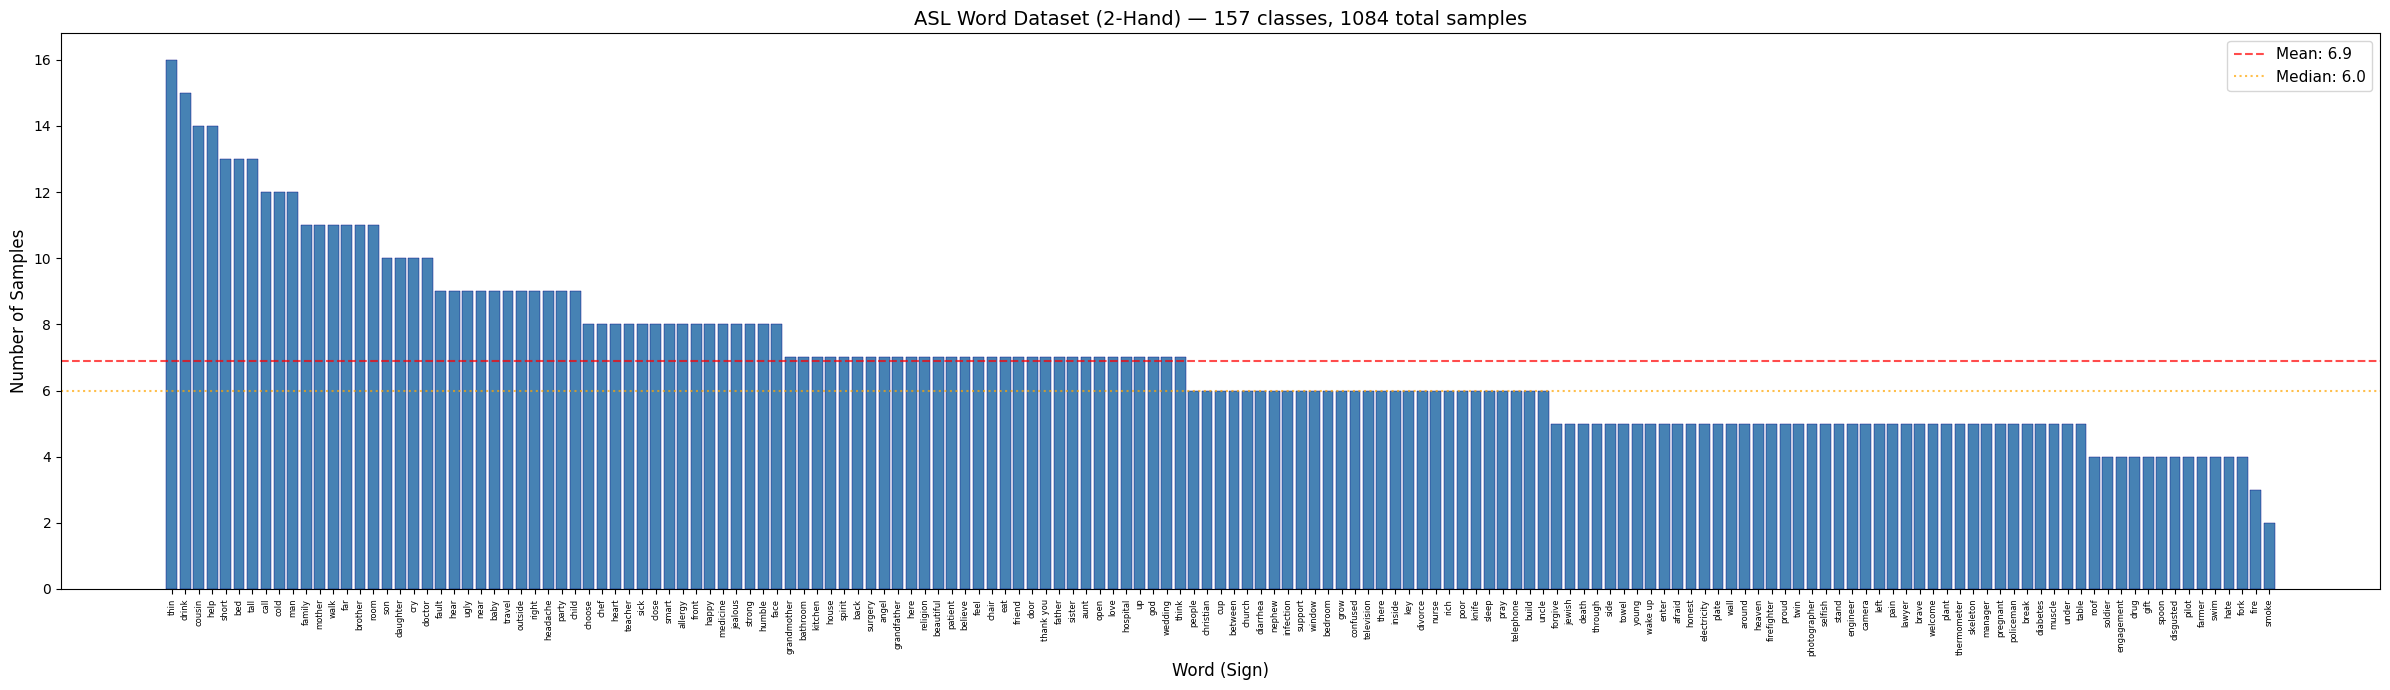


📊 Dataset Summary:
   Total samples    : 1084
   Total classes    : 157
   Features/frame   : 126 (2 hands)
   Min samples/class: 2 (smoke)
   Max samples/class: 16 (thin)
   Mean             : 6.9
   Median           : 6.0


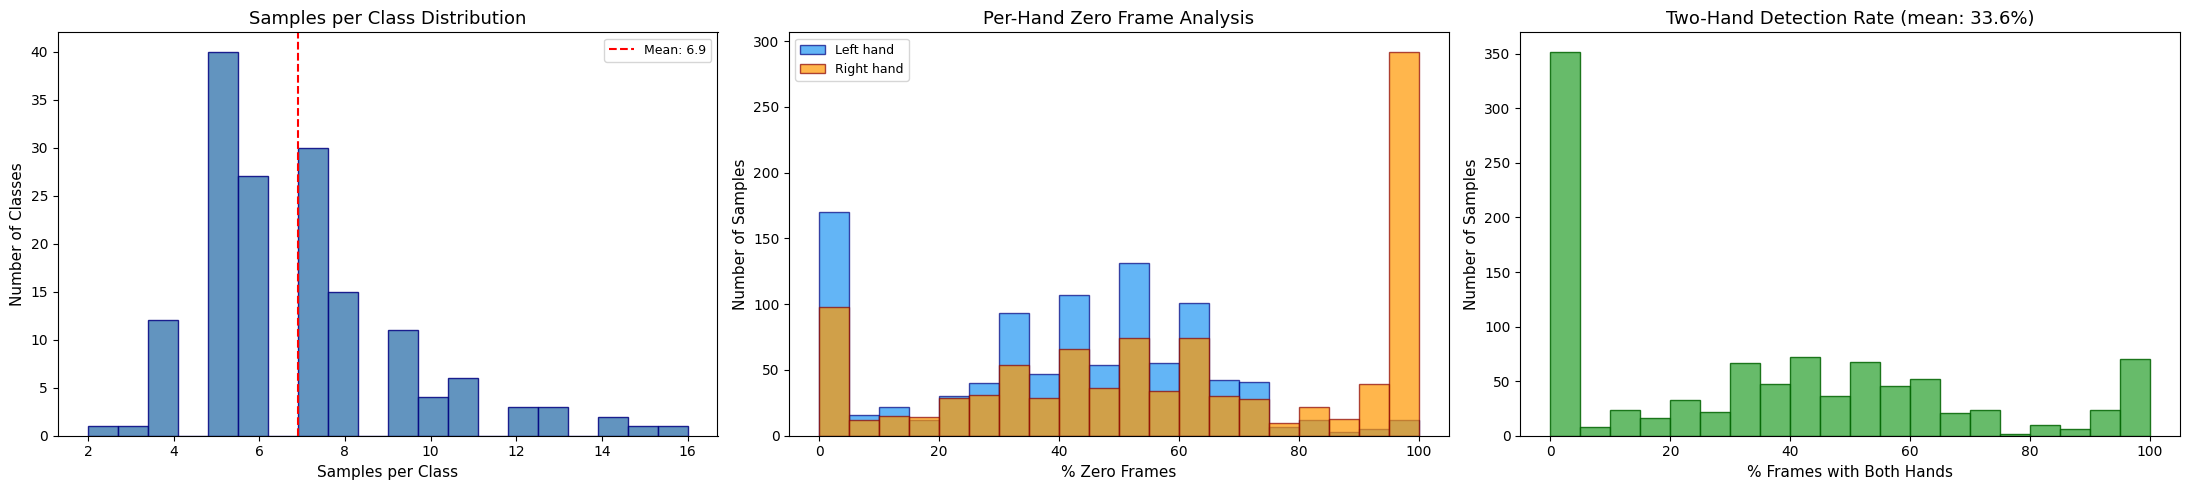


🖐️ Two-Hand Stats (first 1000 samples):
   Mean both-hands frames: 33.6%
   Samples with >50% both: 284


In [21]:
# ============================================
# CELL 6: DATA EXPLORATION
# ============================================
print('=' * 60)
print('📊 DATA EXPLORATION')
print('=' * 60)

# Ensure data is loaded
if 'X' not in dir() or 'y' not in dir():
    data = np.load(NPZ_PATH)
    X, y = data['X'], data['y']

unique_ids, counts = np.unique(y, return_counts=True)
word_names = [id_to_english.get(int(uid), str(uid)) for uid in unique_ids]

sort_idx = np.argsort(counts)[::-1]
sorted_names  = [word_names[i] for i in sort_idx]
sorted_counts = counts[sort_idx]

# PLOT 1: Class distribution
fig, ax = plt.subplots(figsize=(24, 7))
ax.bar(range(len(sorted_names)), sorted_counts, color='steelblue', edgecolor='navy', linewidth=0.3)
ax.set_xticks(range(len(sorted_names)))
ax.set_xticklabels(sorted_names, rotation=90, fontsize=6)
ax.set_xlabel('Word (Sign)', fontsize=12)
ax.set_ylabel('Number of Samples', fontsize=12)
ax.set_title(f'ASL Word Dataset (2-Hand) — {len(unique_ids)} classes, {len(y)} total samples', fontsize=14)
ax.axhline(y=np.mean(sorted_counts), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(sorted_counts):.1f}')
ax.axhline(y=np.median(sorted_counts), color='orange', linestyle=':', alpha=0.7, label=f'Median: {np.median(sorted_counts):.1f}')
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

print(f'\n📊 Dataset Summary:')
print(f'   Total samples    : {len(y)}')
print(f'   Total classes    : {len(unique_ids)}')
print(f'   Features/frame   : {NUM_FEATURES} ({NUM_HANDS} hands)')
print(f'   Min samples/class: {counts.min()} ({word_names[counts.argmin()]})')
print(f'   Max samples/class: {counts.max()} ({word_names[counts.argmax()]})')
print(f'   Mean             : {counts.mean():.1f}')
print(f'   Median           : {np.median(counts):.1f}')

# PLOT 2: Quality analysis
fig, axes = plt.subplots(1, 3, figsize=(22, 5))

axes[0].hist(sorted_counts, bins=20, color='steelblue', edgecolor='navy', alpha=0.85)
axes[0].set_xlabel('Samples per Class', fontsize=11)
axes[0].set_ylabel('Number of Classes', fontsize=11)
axes[0].set_title('Samples per Class Distribution', fontsize=13)
axes[0].axvline(x=np.mean(sorted_counts), color='red', linestyle='--', label=f'Mean: {np.mean(sorted_counts):.1f}')
axes[0].legend(fontsize=9)

# Zero-frame quality for left hand
left_zero = []
right_zero = []
for i in range(min(len(X), 1000)):
    left_sums = np.sum(np.abs(X[i, :, :LANDMARKS_PER_HAND]), axis=1)
    right_sums = np.sum(np.abs(X[i, :, LANDMARKS_PER_HAND:]), axis=1)
    left_zero.append(np.sum(left_sums == 0) / SEQUENCE_LENGTH * 100)
    right_zero.append(np.sum(right_sums == 0) / SEQUENCE_LENGTH * 100)

axes[1].hist(left_zero, bins=20, alpha=0.7, color='#2196F3', edgecolor='navy', label='Left hand')
axes[1].hist(right_zero, bins=20, alpha=0.7, color='#FF9800', edgecolor='darkred', label='Right hand')
axes[1].set_xlabel('% Zero Frames', fontsize=11)
axes[1].set_ylabel('Number of Samples', fontsize=11)
axes[1].set_title('Per-Hand Zero Frame Analysis', fontsize=13)
axes[1].legend(fontsize=9)

# Two-hand detection rate
both_hands = []
for i in range(min(len(X), 1000)):
    left_active = np.any(X[i, :, :LANDMARKS_PER_HAND] != 0, axis=1)
    right_active = np.any(X[i, :, LANDMARKS_PER_HAND:] != 0, axis=1)
    both_active = np.sum(left_active & right_active) / SEQUENCE_LENGTH * 100
    both_hands.append(both_active)

axes[2].hist(both_hands, bins=20, color='#4CAF50', edgecolor='darkgreen', alpha=0.85)
axes[2].set_xlabel('% Frames with Both Hands', fontsize=11)
axes[2].set_ylabel('Number of Samples', fontsize=11)
axes[2].set_title(f'Two-Hand Detection Rate (mean: {np.mean(both_hands):.1f}%)', fontsize=13)

plt.tight_layout()
plt.show()

print(f'\n🖐️ Two-Hand Stats (first 1000 samples):')
print(f'   Mean both-hands frames: {np.mean(both_hands):.1f}%')
print(f'   Samples with >50% both: {np.sum(np.array(both_hands) > 50)}')


In [23]:
# ============================================
# CELL 7: PREPROCESSING & DATA SPLITS (FIXED)
# ============================================
print('=' * 60)
print('🔧 PREPROCESSING & TRAIN/VAL/TEST SPLIT')
print('=' * 60)

# 1. Load Data
data = np.load(NPZ_PATH)
X, y = data['X'], data['y']

# 2. Normalization
original_shape = X.shape
X_flat = X.reshape(-1, NUM_FEATURES)
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)
X = X_flat.reshape(original_shape).astype(np.float32)
print(f'    ✅ StandardScaler applied')

# 3. Label Encoding
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
num_classes = len(encoder.classes_)
y_onehot = to_categorical(y_encoded, num_classes=num_classes)

# 4. Stratified Split
try:
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y_onehot, test_size=TEST_SIZE, random_state=42, stratify=y_encoded
    )
    temp_labels = np.argmax(y_temp, axis=1)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=temp_labels
    )
except ValueError:
    print('⚠️ Some classes have too few samples for stratification. Using random split.')
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y_onehot, test_size=TEST_SIZE, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42
    )

# 5. FIXED CLASS WEIGHTS LOGIC
train_labels = np.argmax(y_train, axis=1)
present_classes = np.unique(train_labels)

# Compute weights only for classes present in the training set
cw_values = compute_class_weight(
    class_weight='balanced',
    classes=present_classes,
    y=train_labels
)
cw_values = np.clip(cw_values, 0.5, 10.0)

# Initialize all classes with 1.0, then update with calculated weights
class_weights = {i: 1.0 for i in range(num_classes)}
for i, class_idx in enumerate(present_classes):
    class_weights[class_idx] = cw_values[i]

print(f'\n📊 Split Summary:')
print(f'    Classes      : {num_classes}')
print(f'    Train        : {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.0f}%)')
print(f'    Validation   : {X_val.shape[0]} ({X_val.shape[0]/len(X)*100:.0f}%)')
print(f'    Test         : {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.0f}%)')
print(f'    Input shape  : {X_train.shape[1:]}')
print(f'    Class weights: {len(present_classes)}/{num_classes} classes weighted — max: {max(class_weights.values()):.2f}')

🔧 PREPROCESSING & TRAIN/VAL/TEST SPLIT
    ✅ StandardScaler applied
⚠️ Some classes have too few samples for stratification. Using random split.

📊 Split Summary:
    Classes      : 157
    Train        : 758 (70%)
    Validation   : 163 (15%)
    Test         : 163 (15%)
    Input shape  : (30, 126)
    Class weights: 155/157 classes weighted — max: 4.89


In [25]:
# ============================================
# CELL 8: BUILD & TRAIN BiLSTM (FULL PARAMETERS)
# ============================================
print('=' * 60)
print('🚀 BUILDING & TRAINING OPTIMIZED BiLSTM MODEL')
print('   Two-Hand Mode | Full Parameters | GPU-Accelerated')
print('=' * 60)

# Clear previous session
tf.keras.backend.clear_session()

BATCH_SIZE_TRAIN = BATCH_SIZE if USE_GPU else 32
print(f'   📦 Batch size: {BATCH_SIZE_TRAIN} ({"GPU" if USE_GPU else "CPU"})')

# --- Data Augmentation ---
def augment_sequence(x, y):
    """Apply augmentations to two-hand landmark sequences."""
    # 1) Gaussian noise
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=0.005)
    x = x + noise

    # 2) Random temporal shift: roll frames by +/-3
    shift = tf.random.uniform([], minval=-3, maxval=4, dtype=tf.int32)
    x = tf.roll(x, shift=shift, axis=0)

    # 3) Random frame dropout: zero out ~10% of frames
    frame_mask = tf.random.uniform([SEQUENCE_LENGTH, 1]) > 0.1
    frame_mask = tf.cast(frame_mask, tf.float32)
    x = x * frame_mask

    # 4) Random scaling (simulate distance variation)
    scale = tf.random.uniform([], 0.85, 1.15)
    x = x * scale

    # 5) Random hand swap (data augmentation for symmetry)
    # Swap left/right hand landmarks with 20% probability
    swap = tf.random.uniform([]) < 0.2
    if swap:
        left = x[:, :LANDMARKS_PER_HAND]
        right = x[:, LANDMARKS_PER_HAND:]
        x = tf.concat([right, left], axis=1)

    return x, y

# --- tf.data Pipelines ---
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=min(len(X_train), 10000), seed=42, reshuffle_each_iteration=True)
train_ds = train_ds.map(augment_sequence, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE_TRAIN).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.batch(BATCH_SIZE_TRAIN).prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(BATCH_SIZE_TRAIN).prefetch(AUTOTUNE)

print(f'   ✅ tf.data pipelines with augmentation ready')
print(f'   ✅ Class weights for {len(class_weights)} classes')

# --- Temporal Attention Layer ---
class TemporalAttention(tf.keras.layers.Layer):
    """Learnable attention over time steps."""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)

    def call(self, x):
        e = tf.nn.tanh(tf.matmul(x, self.W) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = tf.reduce_sum(x * a, axis=1)
        return output

# --- Build Model (Full Parameters) ---
with tf.device(DEVICE):
    model = Sequential([
        Input(shape=(SEQUENCE_LENGTH, NUM_FEATURES), name='landmark_sequence'),

        # BiLSTM block 1 — captures broad temporal patterns from both hands
        Bidirectional(LSTM(LSTM_UNITS_1, return_sequences=True,
                           recurrent_dropout=0.0,
                           kernel_regularizer=tf.keras.regularizers.l2(L2_REG)),
                      name='bilstm_1'),
        BatchNormalization(name='bn_1'),
        tf.keras.layers.SpatialDropout1D(DROPOUT_RATE, name='sdrop_1'),

        # BiLSTM block 2 — refines temporal features
        Bidirectional(LSTM(LSTM_UNITS_2, return_sequences=True,
                           kernel_regularizer=tf.keras.regularizers.l2(L2_REG)),
                      name='bilstm_2'),
        BatchNormalization(name='bn_2'),
        tf.keras.layers.SpatialDropout1D(DROPOUT_RATE, name='sdrop_2'),

        # LSTM block 3 — final temporal encoding
        LSTM(LSTM_UNITS_3, return_sequences=True,
             kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
             name='lstm_3'),
        BatchNormalization(name='bn_3'),

        # Temporal Attention — focus on discriminative frames
        TemporalAttention(name='temporal_attention'),
        Dropout(DROPOUT_RATE, name='drop_att'),

        # Dense classifier head
        Dense(DENSE_UNITS, activation='relu',
              kernel_initializer='he_normal',
              kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
              name='dense_1'),
        BatchNormalization(name='bn_dense'),
        Dropout(DROPOUT_RATE, name='drop_dense'),

        Dense(DENSE_UNITS // 2, activation='relu',
              kernel_initializer='he_normal',
              kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
              name='dense_2'),
        BatchNormalization(name='bn_dense_2'),
        Dropout(DROPOUT_RATE * 0.5, name='drop_dense_2'),

        Dense(num_classes, activation='softmax', dtype='float32', name='output')
    ], name='ASL_Word_BiLSTM_2Hand')

# Optimizer with gradient clipping
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    clipnorm=GRAD_CLIP_NORM
)

# Loss with label smoothing
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTH)

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=['accuracy']
)

print('\n📐 Model Architecture:')
model.summary()
print(f'\n🖥️  Training on: {DEVICE}')
print(f'🖐️  Input: {NUM_HANDS} hands x {LANDMARKS_PER_HAND} features = {NUM_FEATURES} total')

# --- Callbacks ---
callbacks = [
    ModelCheckpoint(
        str(OUTPUT_DIR / 'asl_word_lstm_model_best.h5'),
        monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
    ),
    EarlyStopping(
        monitor='val_loss', patience=25, restore_best_weights=True, verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=8, min_lr=1e-7, verbose=1
    ),
    tf.keras.callbacks.TerminateOnNaN()
]

# --- Train ---
print('\n🚀 Starting training...')
print(f'   Device       : {DEVICE}')
print(f'   Batch size   : {BATCH_SIZE_TRAIN}')
print(f'   Max epochs   : {EPOCHS}')
print(f'   LR           : {LEARNING_RATE}')
print(f'   Label smooth : {LABEL_SMOOTH}')
print(f'   Grad clip    : {GRAD_CLIP_NORM}')
print(f'   Augmentation : ON (noise + shift + dropout + scale + hand swap)')
start_time = time.time()

with tf.device(DEVICE):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )

training_time = time.time() - start_time
print(f'\n✅ Training complete in {training_time:.1f}s ({training_time/60:.1f} min)')

# Save final model + class mapping
model.save(str(OUTPUT_DIR / 'asl_word_lstm_model_final.h5'))
class_df = pd.DataFrame({
    'model_class_index': range(num_classes),
    'word_id': encoder.classes_.tolist()
})
class_df.to_csv(OUTPUT_DIR / 'asl_word_classes.csv', index=False)
print(f'\n💾 Final model : {OUTPUT_DIR / "asl_word_lstm_model_final.h5"}')
print(f'💾 Best model  : {OUTPUT_DIR / "asl_word_lstm_model_best.h5"}')
print(f'💾 Classes CSV : {OUTPUT_DIR / "asl_word_classes.csv"}')


🚀 BUILDING & TRAINING OPTIMIZED BiLSTM MODEL
   Two-Hand Mode | Full Parameters | GPU-Accelerated
   📦 Batch size: 64 (GPU)
   ✅ tf.data pipelines with augmentation ready
   ✅ Class weights for 157 classes

📐 Model Architecture:


Model: "ASL_Word_BiLSTM_2Hand"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bilstm_1 (Bidirectional)        │ (None, 30, 1024)       │     2,617,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 30, 1024)       │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sdrop_1 (SpatialDropout1D)      │ (None, 30, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm_2 (Bidirectional)        │ (None, 30, 512)        │     2,623,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 30, 512)        │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sdrop_2 (SpatialDropout1D)      │ (None, 30, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 30, 128)        │       328,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 30, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ temporal_attention              │ (None, 128)            │           158 │
│ (TemporalAttention)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_att (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_dense (BatchNormalization)   │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_dense (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_dense_2 (BatchNormalization) │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_dense_2 (Dropout)          │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 157)            │        40,349 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,816,635 (22.19 MB)

 Trainable params: 5,811,771 (22.17 MB)

 Non-trainable params: 4,864 (19.00 KB)


🖥️  Training on: /GPU:0
🖐️  Input: 2 hands x 63 features = 126 total

🚀 Starting training...
   Device       : /GPU:0
   Batch size   : 64
   Max epochs   : 200
   LR           : 0.0005
   Label smooth : 0.1
   Grad clip    : 1.0
   Augmentation : ON (noise + shift + dropout + scale + hand swap)
Epoch 1/200


I0000 00:00:1771552975.768610     183 cuda_dnn.cc:529] Loaded cuDNN version 91002


11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0060 - loss: 6.3251 
Epoch 1: val_accuracy improved from -inf to 0.00613, saving model to /kaggle/working/asl_word_lstm_model_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.0061 - loss: 6.3226 - val_accuracy: 0.0061 - val_loss: 5.5230 - learning_rate: 5.0000e-04
Epoch 2/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0057 - loss: 6.5154 
Epoch 2: val_accuracy improved from 0.00613 to 0.01840, saving model to /kaggle/working/asl_word_lstm_model_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.0065 - loss: 6.4765 - val_accuracy: 0.0184 - val_loss: 5.5066 - learning_rate: 5.0000e-04
Epoch 3/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.0046 - loss: 6.2013
Epoch 3: val_accuracy did not improve from 0.01840
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.0049 - loss: 6.2055 - val_accuracy: 0.0000e+00 - val_loss: 5.4948 - learning_rate: 5.0000e-04
Epoch 4/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.0030 - loss: 6.0501 
Epoch 4: val_accuracy did not improve from 0.01840
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.0030 - loss: 6.0705 - val_accuracy: 0.0123 - val_loss: 5.4916 - learning_rate: 5.0000e-04
Epoch 5/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0169 - loss: 5.9569
Epoch 5: val_accuracy did not improve from 0.01840
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.0162 - loss: 5.9745 - val_accuracy: 0.0123 - val_loss: 5.4859 - learning_rate: 5.0000e-04
Epoch 6/

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.0148 - loss: 6.1267 - val_accuracy: 0.0245 - val_loss: 5.4646 - learning_rate: 5.0000e-04
Epoch 9/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0145 - loss: 5.8704
Epoch 9: val_accuracy did not improve from 0.02454
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.0141 - loss: 5.8807 - val_accuracy: 0.0184 - val_loss: 5.4209 - learning_rate: 5.0000e-04
Epoch 10/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0074 - loss: 6.0583
Epoch 10: val_accuracy did not improve from 0.02454
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0075 - loss: 6.0385 - val_accuracy: 0.0184 - val_loss: 5.4222 - learning_rate: 5.0000e-04
Epoch 11/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0104 - loss: 5.6945
Epoch 11: val_accuracy did not improve from 0.02454
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.0102 - loss: 5.7143 - val_accuracy: 0.0245 - val_loss: 5.3959 - learning_rate: 5.0000e-04
Epoch 12/

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.0128 - loss: 5.6324 - val_accuracy: 0.0368 - val_loss: 5.3597 - learning_rate: 5.0000e-04
Epoch 18/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.0188 - loss: 5.5058
Epoch 18: val_accuracy did not improve from 0.03681
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.0197 - loss: 5.5270 - val_accuracy: 0.0368 - val_loss: 5.3361 - learning_rate: 5.0000e-04
Epoch 19/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.0099 - loss: 5.7299
Epoch 19: val_accuracy did not improve from 0.03681
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.0108 - loss: 5.7218 - val_accuracy: 0.0368 - val_loss: 5.3059 - learning_rate: 5.0000e-04
Epoch 20/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0142 - loss: 5.7710
Epoch 20: val_accuracy improved from 0.03681 to 0.04294, saving model to /kaggle/working/asl_word_lstm_model_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.0139 - loss: 5.7578 - val_accuracy: 0.0429 - val_loss: 5.3074 - learning_rate: 5.0000e-04
Epoch 21/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0190 - loss: 5.6739
Epoch 21: val_accuracy did not improve from 0.04294
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.0197 - loss: 5.6693 - val_accuracy: 0.0368 - val_loss: 5.3042 - learning_rate: 5.0000e-04
Epoch 22/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0193 - loss: 5.5555
Epoch 22: val_accuracy did not improve from 0.04294
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0188 - loss: 5.5472 - val_accuracy: 0.0368 - val_loss: 5.3159 - learning_rate: 5.0000e-04
Epoch 23/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0264 - loss: 5.4768
Epoch 23: val_accuracy did not improve from 0.04294
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0262 - loss: 5.4886 - val_accuracy: 0.0429 - val_loss: 5.3564 - learning_rate: 5.0000e-04
Epoch 2

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.0109 - loss: 5.3739 - val_accuracy: 0.0491 - val_loss: 5.3396 - learning_rate: 5.0000e-04
Epoch 25/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0219 - loss: 5.4886
Epoch 25: val_accuracy did not improve from 0.04908
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0207 - loss: 5.4994 - val_accuracy: 0.0184 - val_loss: 5.3941 - learning_rate: 5.0000e-04
Epoch 26/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0179 - loss: 5.6176
Epoch 26: val_accuracy did not improve from 0.04908
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0180 - loss: 5.6062 - val_accuracy: 0.0368 - val_loss: 5.3931 - learning_rate: 5.0000e-04
Epoch 27/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0235 - loss: 5.3876
Epoch 27: val_accuracy did not improve from 0.04908
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0223 - loss: 5.3944 - val_accuracy: 0.0307 - val_loss: 5.3809 - learning_rate: 5.0000e-04
Epoch 2

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.0274 - loss: 5.1145 - val_accuracy: 0.0613 - val_loss: 5.2195 - learning_rate: 2.5000e-04
Epoch 47/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0298 - loss: 5.2504
Epoch 47: val_accuracy did not improve from 0.06135
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0297 - loss: 5.2468 - val_accuracy: 0.0552 - val_loss: 5.2296 - learning_rate: 2.5000e-04
Epoch 48/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0225 - loss: 5.2816
Epoch 48: val_accuracy did not improve from 0.06135
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0235 - loss: 5.2685 - val_accuracy: 0.0613 - val_loss: 5.2263 - learning_rate: 2.5000e-04
Epoch 49/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0292 - loss: 5.1332
Epoch 49: val_accuracy did not improve from 0.06135
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0300 - loss: 5.1389 - val_accuracy: 0.0429 - val_loss: 5.2276 - learning_rate: 2.5000e-04
Epoch 5

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.0406 - loss: 5.1189 - val_accuracy: 0.0675 - val_loss: 5.1875 - learning_rate: 2.5000e-04
Epoch 52/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0270 - loss: 5.2515
Epoch 52: val_accuracy did not improve from 0.06748
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0277 - loss: 5.2455 - val_accuracy: 0.0429 - val_loss: 5.1888 - learning_rate: 2.5000e-04
Epoch 53/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0387 - loss: 5.2097
Epoch 53: val_accuracy did not improve from 0.06748
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0378 - loss: 5.1949 - val_accuracy: 0.0429 - val_loss: 5.1903 - learning_rate: 2.5000e-04
Epoch 54/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0282 - loss: 5.1861
Epoch 54: val_accuracy did not improve from 0.06748
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0283 - loss: 5.1792 - val_accuracy: 0.0245 - val_loss: 5.2136 - learning_rate: 2.5000e-04
Epoch 5

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.0422 - loss: 4.9471 - val_accuracy: 0.0736 - val_loss: 5.1868 - learning_rate: 2.5000e-04
Epoch 64/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0311 - loss: 4.9850
Epoch 64: val_accuracy did not improve from 0.07362
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.0328 - loss: 4.9871 - val_accuracy: 0.0675 - val_loss: 5.1669 - learning_rate: 2.5000e-04
Epoch 65/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.0275 - loss: 4.8019
Epoch 65: val_accuracy did not improve from 0.07362
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.0275 - loss: 4.8298 - val_accuracy: 0.0491 - val_loss: 5.1720 - learning_rate: 2.5000e-04
Epoch 66/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0499 - loss: 4.9673
Epoch 66: val_accuracy did not improve from 0.07362
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0492 - loss: 4.9745 - val_accuracy: 0.0491 - val_loss: 5.1861 - learning_rate: 2.5000e-04
Epoch 6

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.0842 - loss: 4.4873 - val_accuracy: 0.0798 - val_loss: 4.8862 - learning_rate: 2.5000e-04
Epoch 132/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.0801 - loss: 4.5247
Epoch 132: val_accuracy improved from 0.07975 to 0.09202, saving model to /kaggle/working/asl_word_lstm_model_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.0802 - loss: 4.5198 - val_accuracy: 0.0920 - val_loss: 4.8742 - learning_rate: 2.5000e-04
Epoch 133/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0769 - loss: 4.4610
Epoch 133: val_accuracy did not improve from 0.09202
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.0756 - loss: 4.4696 - val_accuracy: 0.0798 - val_loss: 4.8682 - learning_rate: 2.5000e-04
Epoch 134/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0875 - loss: 4.4769
Epoch 134: val_accuracy did not improve from 0.09202
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0870 - loss: 4.4782 - val_accuracy: 0.0920 - val_loss: 4.8732 - learning_rate: 2.5000e-04
Epoch 135/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0859 - loss: 4.4351
Epoch 135: val_accuracy did not improve from 0.09202
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0832 - loss: 4.4402 - val_accuracy: 0.0736 - val_loss: 4.8917 - learning_rate: 2.5000e-04
E

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.1233 - loss: 4.2836 - val_accuracy: 0.1104 - val_loss: 4.8699 - learning_rate: 2.5000e-04
Epoch 138/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0937 - loss: 4.4822
Epoch 138: val_accuracy did not improve from 0.11043
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.0911 - loss: 4.4795 - val_accuracy: 0.0736 - val_loss: 4.8559 - learning_rate: 2.5000e-04
Epoch 139/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.0859 - loss: 4.4176
Epoch 139: val_accuracy did not improve from 0.11043
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.0859 - loss: 4.4226 - val_accuracy: 0.0920 - val_loss: 4.8606 - learning_rate: 2.5000e-04
Epoch 140/200
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0938 - loss: 4.3841
Epoch 140: val_accuracy did not improve from 0.11043
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.0928 - loss: 4.3957 - val_accuracy: 0.0798 - val_loss: 4.8498 - learning_rate: 2.5000e-04
E


✅ Training complete in 128.9s (2.1 min)

💾 Final model : /kaggle/working/asl_word_lstm_model_final.h5
💾 Best model  : /kaggle/working/asl_word_lstm_model_best.h5
💾 Classes CSV : /kaggle/working/asl_word_classes.csv


📈 MODEL EVALUATION & VISUALIZATION DASHBOARD



🎯 Test Results (Two-Hand Model):
   Top-1 Accuracy : 0.0736 (7.36%)
   Top-5 Accuracy : 0.2086 (20.86%)
   Test samples   : 163
   Classes        : 157
   Features       : 126 (2 hands)


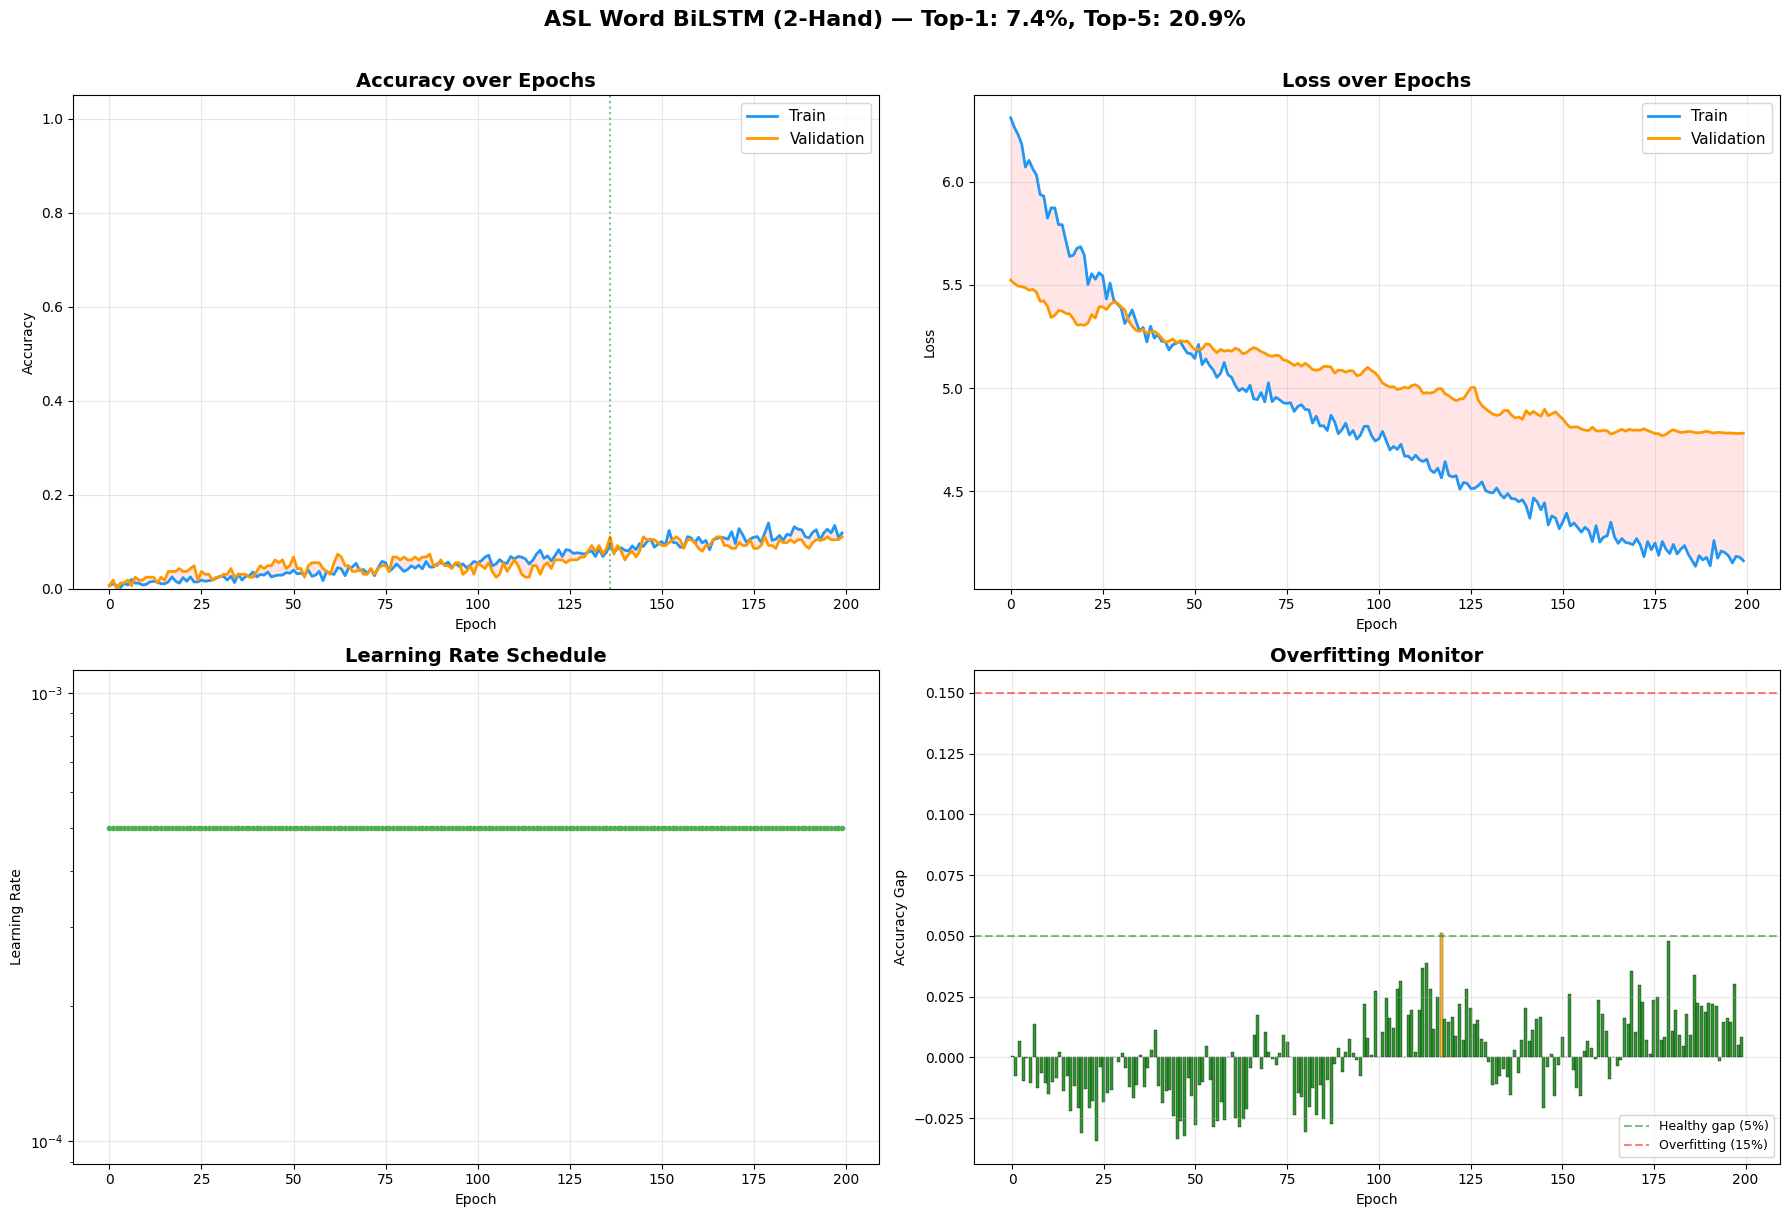

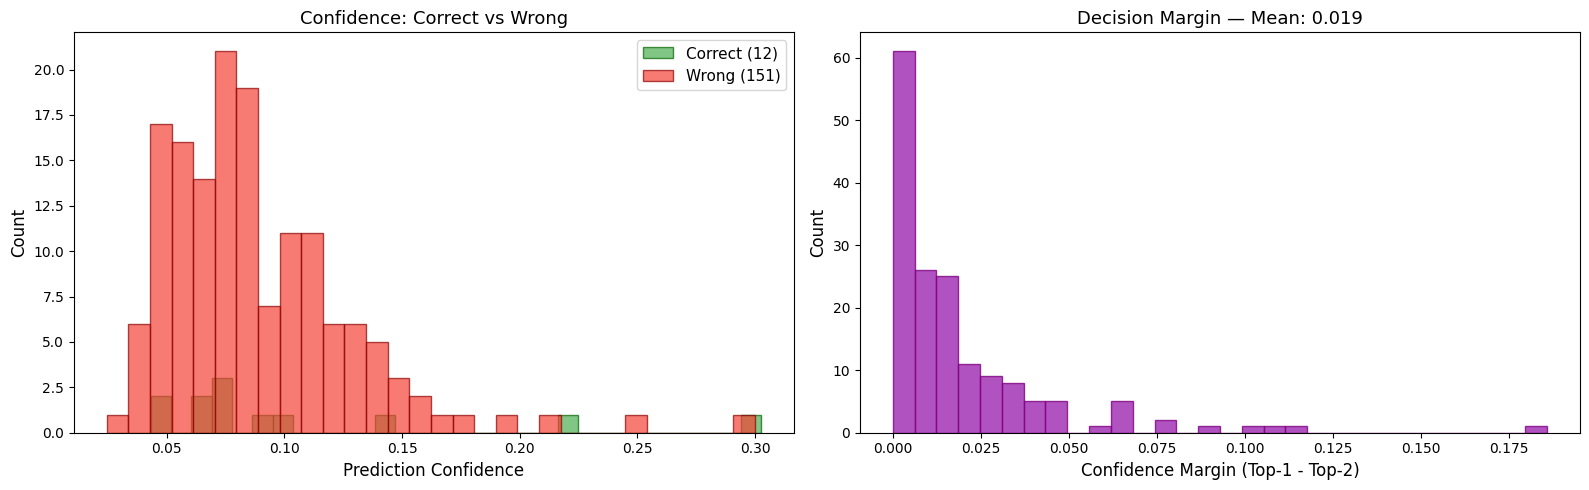


📋 Classification Report:
              precision    recall  f1-score   support

       drink       0.00      0.00      0.00         5
       chair       0.00      0.00      0.00         0
        help       0.00      0.00      0.00         2
        thin       0.00      0.00      0.00         3
        walk       0.00      0.00      0.00         1
      mother       0.00      0.00      0.00         3
       table       0.00      0.00      0.00         1
         bed       0.00      0.00      0.00         2
      family       0.17      0.50      0.25         2
         man       0.00      0.00      0.00         3
        tall       0.00      0.00      0.00         1
      doctor       0.00      0.00      0.00         2
         eat       0.00      0.00      0.00         2
       short       0.00      0.00      0.00         2
    medicine       0.00      0.00      0.00         1
       right       0.00      0.00      0.00         0
         son       0.00      0.00      0.00         0
 

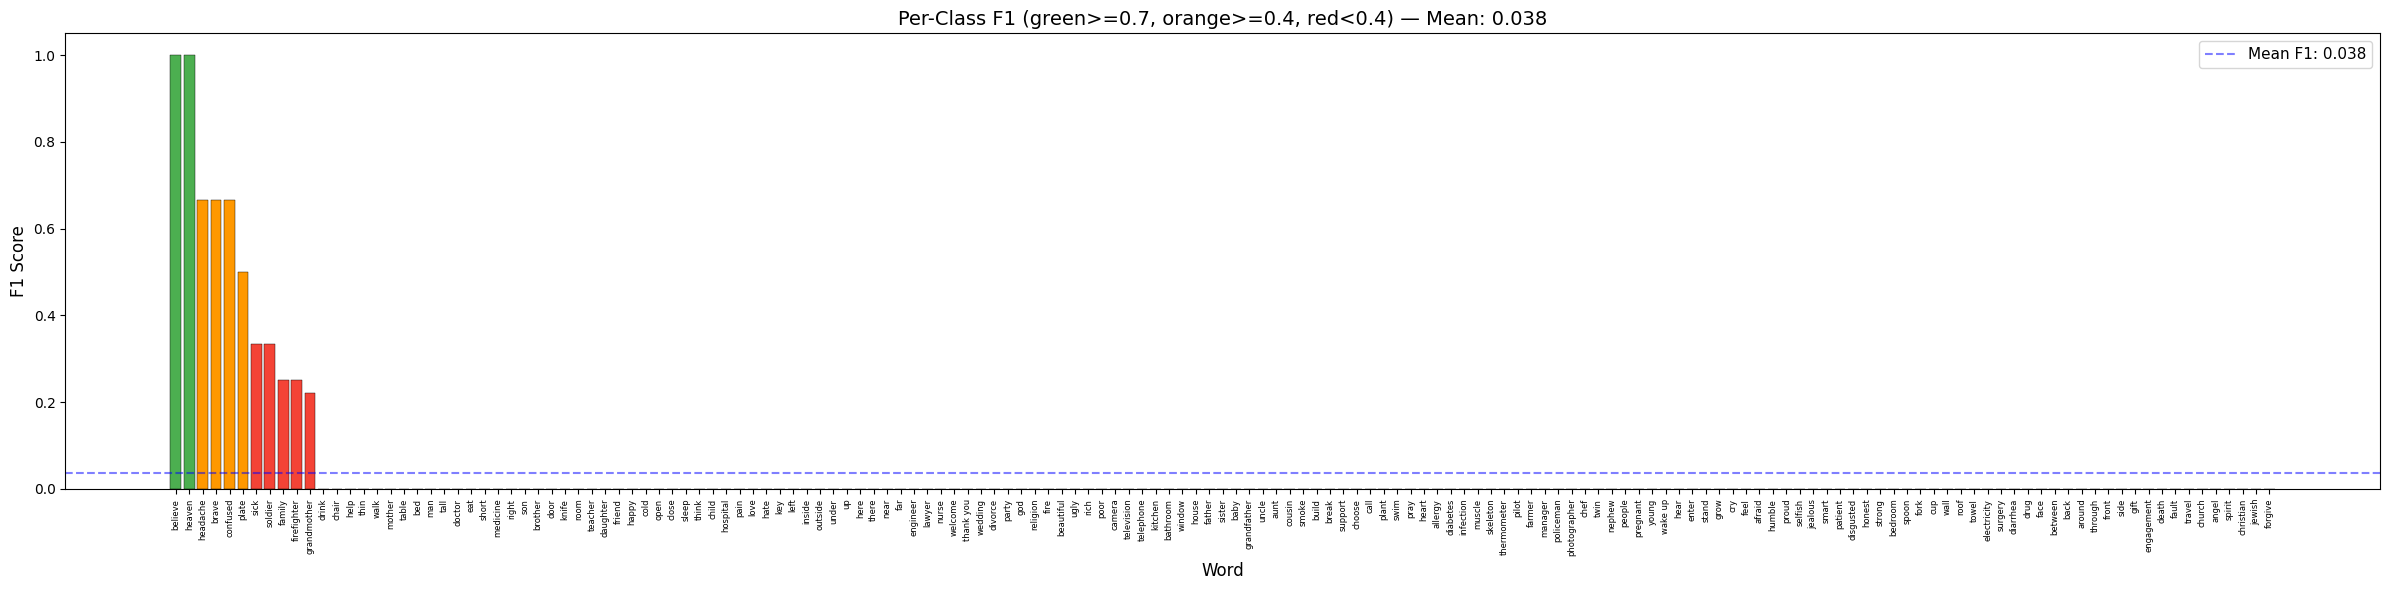

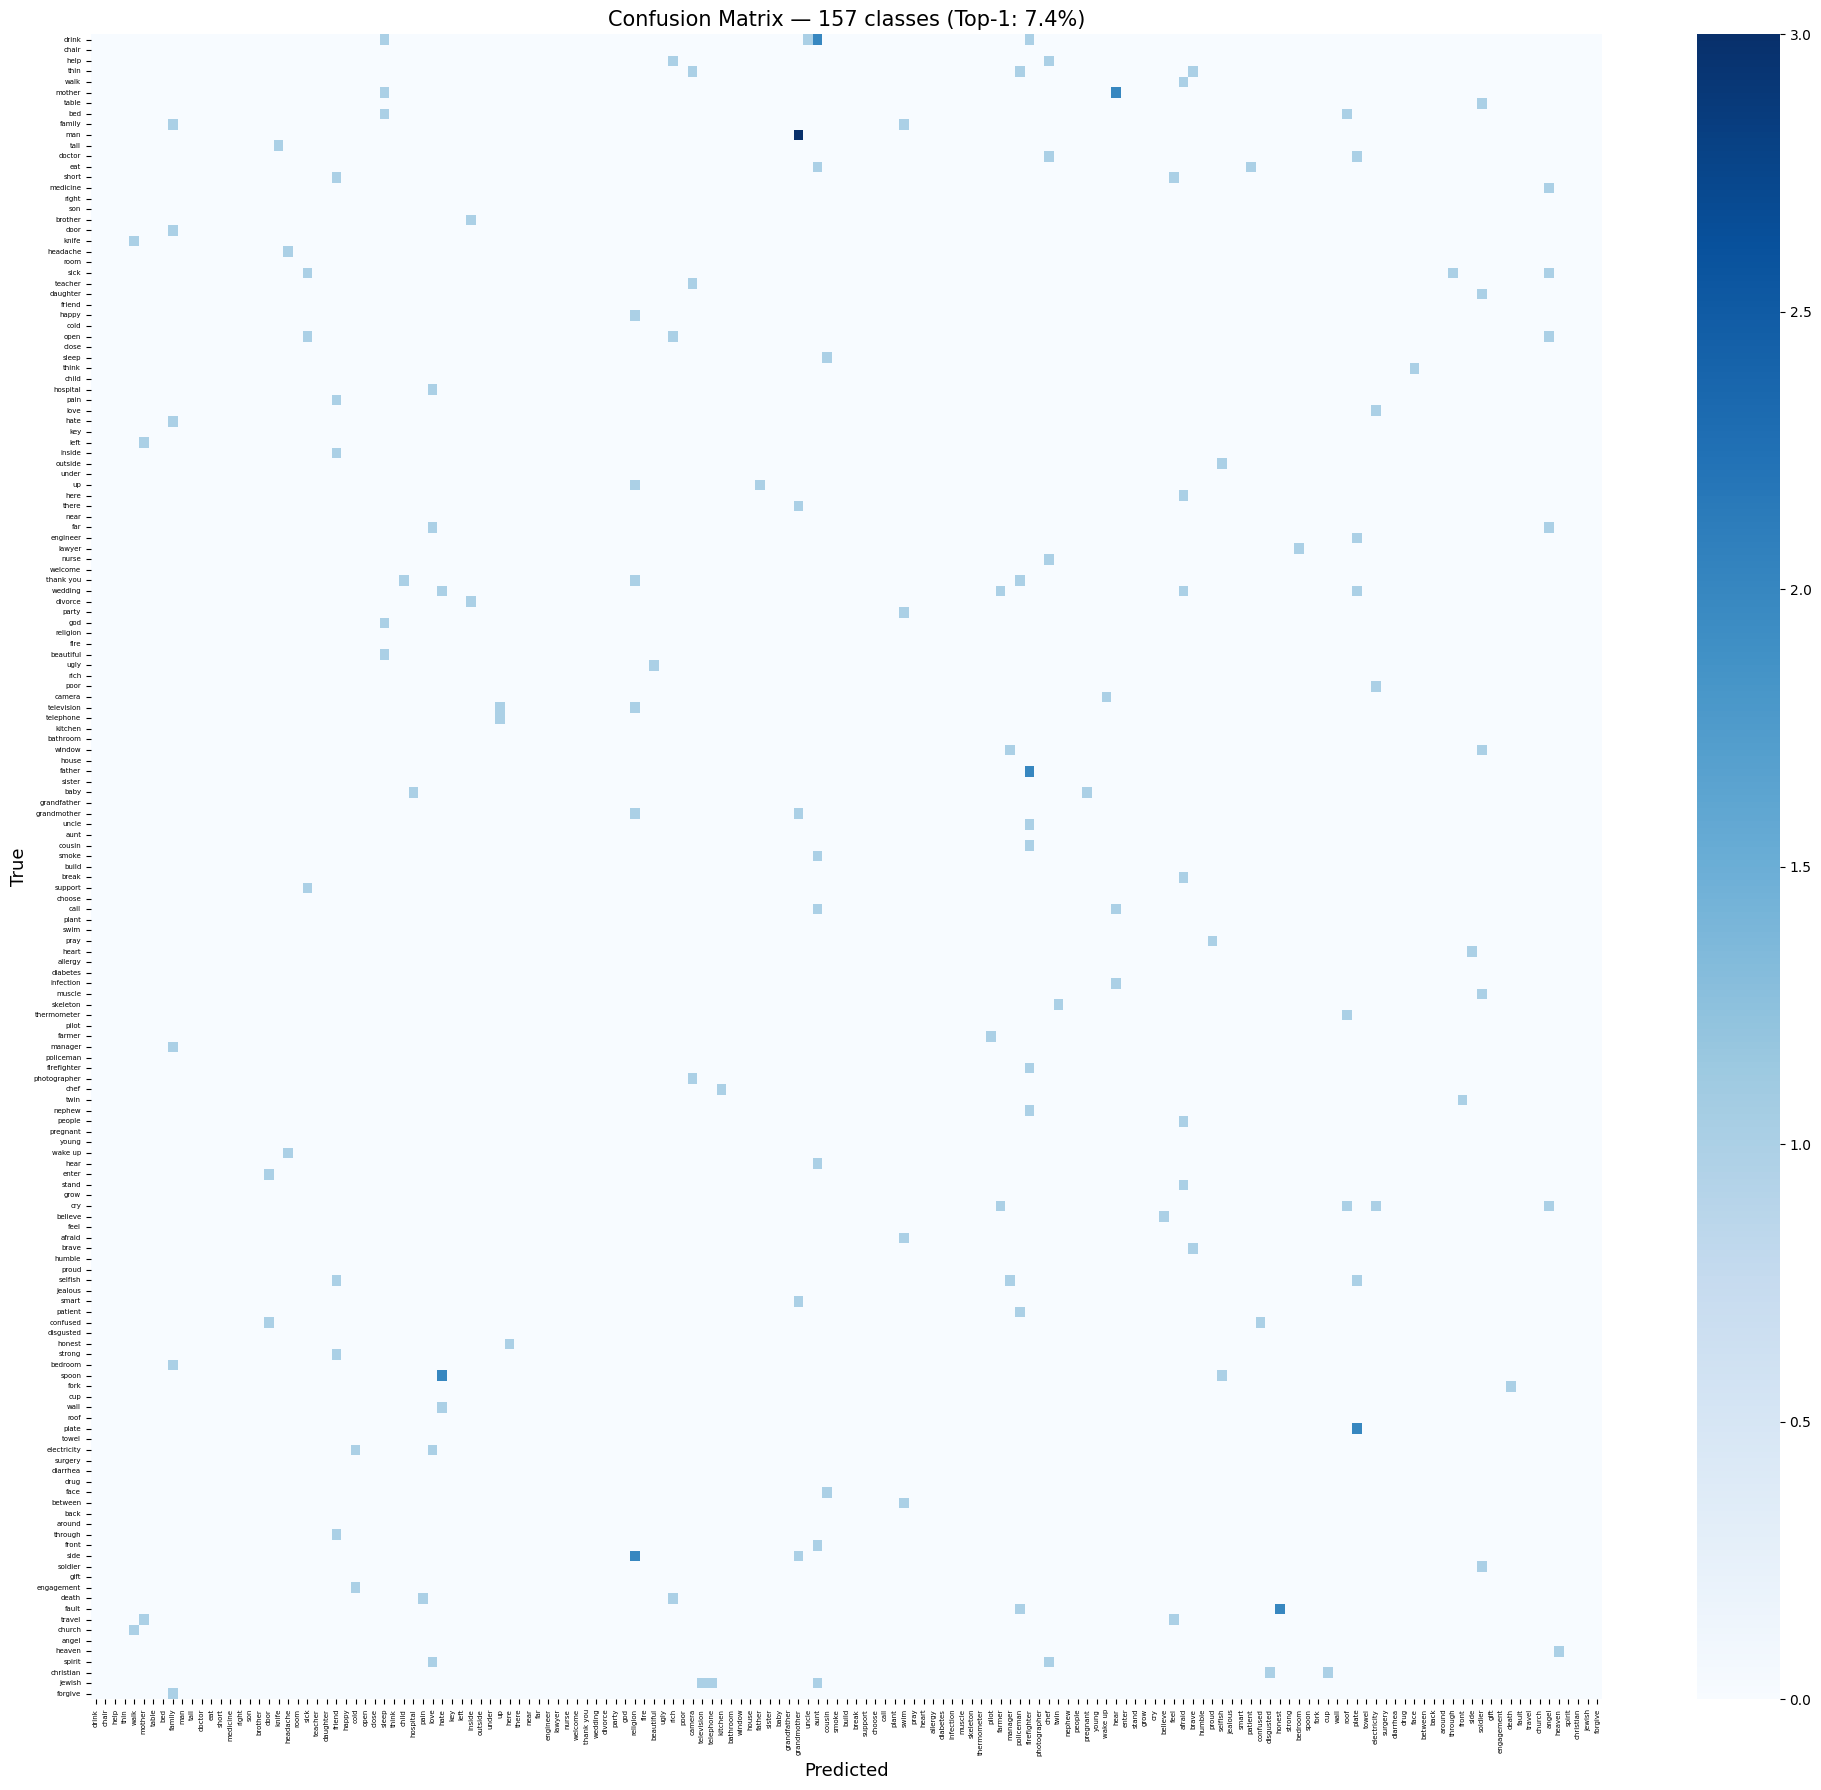

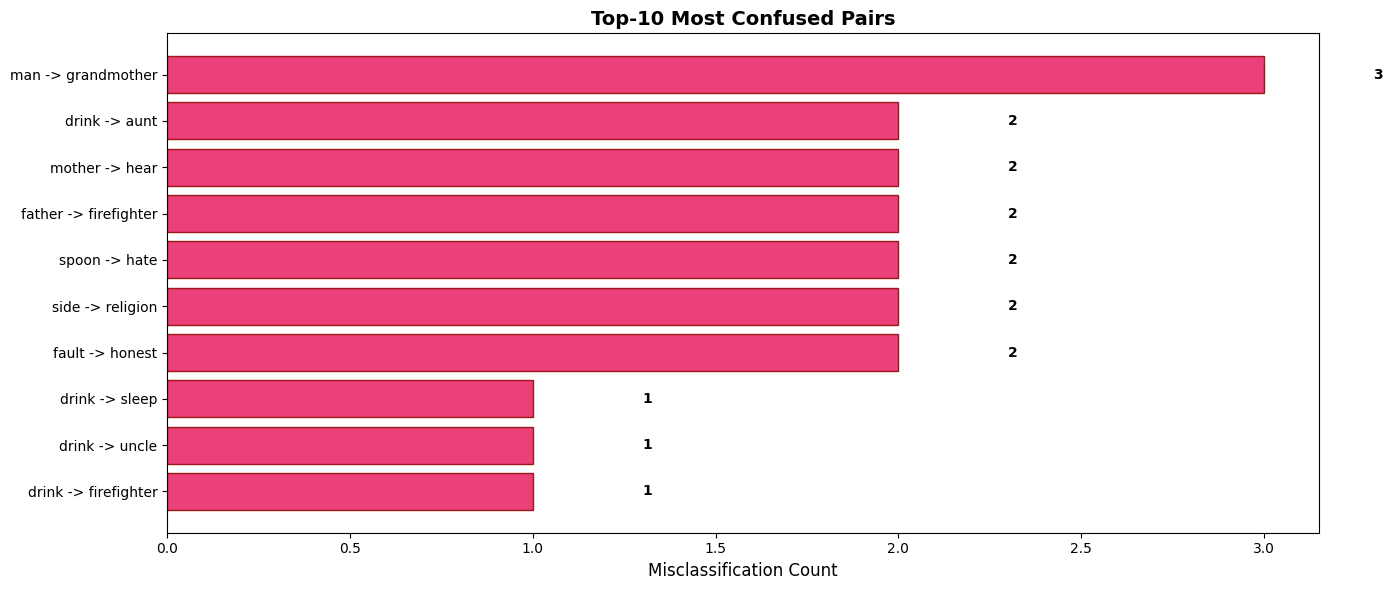

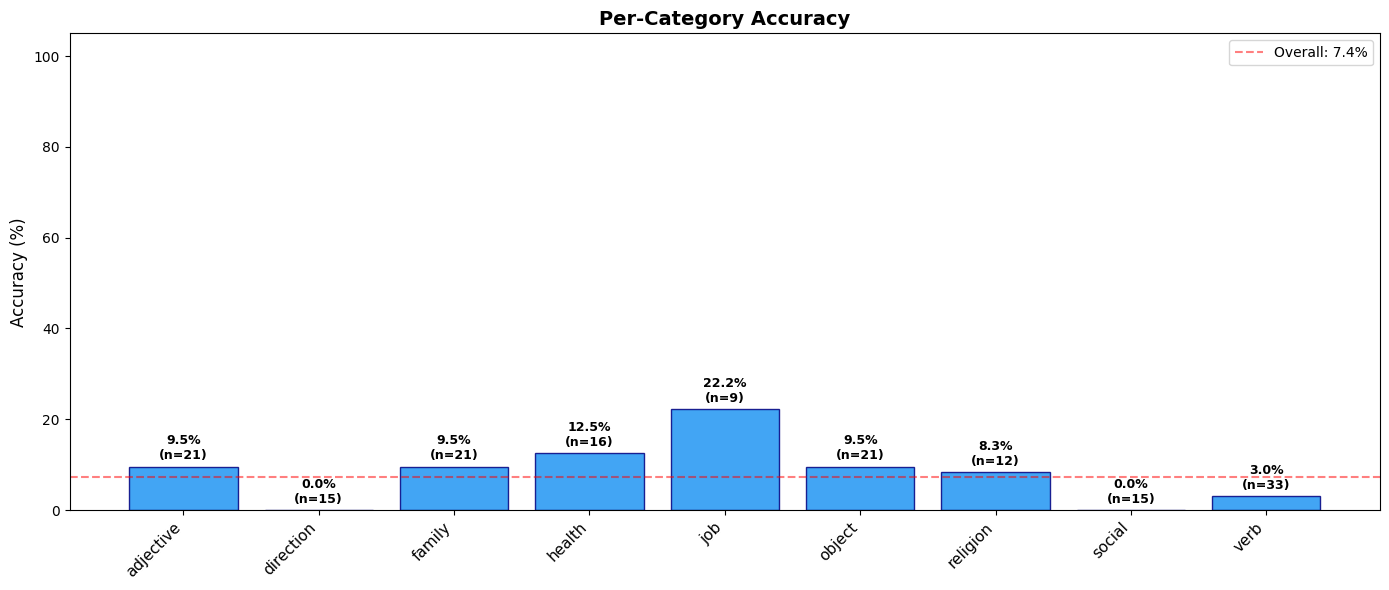

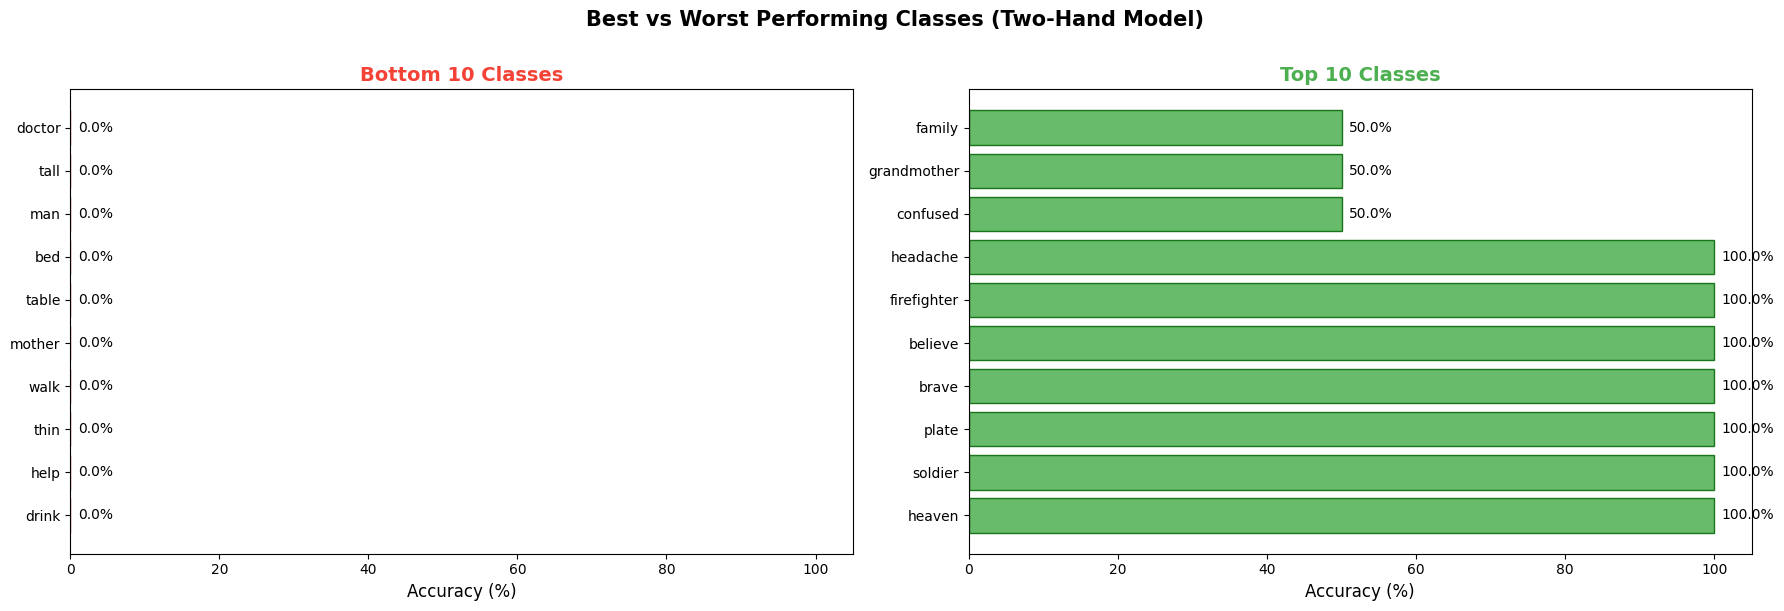

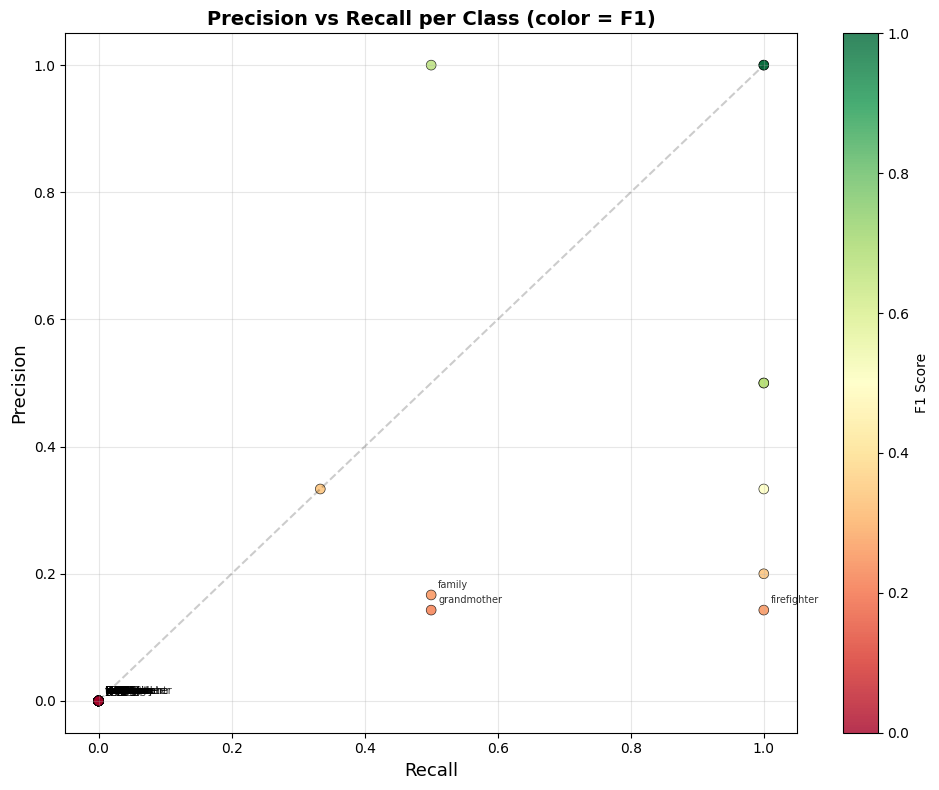


✅ Evaluation Dashboard complete!


In [26]:
# ============================================
# CELL 9: EVALUATION & VISUALIZATION DASHBOARD
# ============================================
print('=' * 60)
print('📈 MODEL EVALUATION & VISUALIZATION DASHBOARD')
print('=' * 60)

# Load best checkpoint
best_model = tf.keras.models.load_model(
    str(OUTPUT_DIR / 'asl_word_lstm_model_best.h5'),
    custom_objects={'TemporalAttention': TemporalAttention}
)

# Predict
eval_batch = 64 if USE_GPU else 32
eval_ds = tf.data.Dataset.from_tensor_slices((X_test,)).batch(eval_batch).prefetch(tf.data.AUTOTUNE)

with tf.device(DEVICE):
    proba = best_model.predict(eval_ds, verbose=0)

y_pred = np.argmax(proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# Top-1 accuracy
top1_acc = (y_pred == y_true).mean()

# Top-5 accuracy
top5_correct = 0
for i in range(len(y_true)):
    top5 = np.argsort(proba[i])[-5:]
    if y_true[i] in top5:
        top5_correct += 1
top5_acc = top5_correct / len(y_true)

print(f'\n🎯 Test Results (Two-Hand Model):')
print(f'   Top-1 Accuracy : {top1_acc:.4f} ({top1_acc*100:.2f}%)')
print(f'   Top-5 Accuracy : {top5_acc:.4f} ({top5_acc*100:.2f}%)')
print(f'   Test samples   : {len(y_true)}')
print(f'   Classes        : {num_classes}')
print(f'   Features       : {NUM_FEATURES} ({NUM_HANDS} hands)')

# =============================================
# PLOT 1: Training Dashboard (4 panels)
# =============================================
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

axes[0, 0].plot(history.history['accuracy'], label='Train', linewidth=2, color='#2196F3')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation', linewidth=2, color='#FF9800')
axes[0, 0].fill_between(range(len(history.history['accuracy'])),
                         history.history['accuracy'], history.history['val_accuracy'],
                         alpha=0.1, color='red')
axes[0, 0].set_title('Accuracy over Epochs', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim([0, 1.05])
best_epoch = np.argmax(history.history['val_accuracy'])
axes[0, 0].axvline(x=best_epoch, color='green', linestyle=':', alpha=0.5)

axes[0, 1].plot(history.history['loss'], label='Train', linewidth=2, color='#2196F3')
axes[0, 1].plot(history.history['val_loss'], label='Validation', linewidth=2, color='#FF9800')
axes[0, 1].fill_between(range(len(history.history['loss'])),
                         history.history['loss'], history.history['val_loss'],
                         alpha=0.1, color='red')
axes[0, 1].set_title('Loss over Epochs', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

if 'lr' in history.history:
    lr_values = history.history['lr']
else:
    lr_values = [LEARNING_RATE] * len(history.history['loss'])
axes[1, 0].plot(lr_values, linewidth=2, color='#4CAF50', marker='o', markersize=3)
axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

train_acc = np.array(history.history['accuracy'])
val_acc = np.array(history.history['val_accuracy'])
gap = train_acc - val_acc
axes[1, 1].bar(range(len(gap)), gap, color=['green' if g < 0.05 else 'orange' if g < 0.15 else 'red' for g in gap],
               edgecolor='black', linewidth=0.3, alpha=0.8)
axes[1, 1].axhline(y=0.05, color='green', linestyle='--', alpha=0.5, label='Healthy gap (5%)')
axes[1, 1].axhline(y=0.15, color='red', linestyle='--', alpha=0.5, label='Overfitting (15%)')
axes[1, 1].set_title('Overfitting Monitor', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy Gap')
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle(f'ASL Word BiLSTM (2-Hand) — Top-1: {top1_acc*100:.1f}%, Top-5: {top5_acc*100:.1f}%',
             fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

# =============================================
# PLOT 2: Confidence Distribution
# =============================================
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

correct_mask = y_pred == y_true
correct_conf = np.max(proba[correct_mask], axis=1)
wrong_conf   = np.max(proba[~correct_mask], axis=1) if np.sum(~correct_mask) > 0 else np.array([])

axes[0].hist(correct_conf, bins=30, alpha=0.7, color='#4CAF50', edgecolor='darkgreen', label=f'Correct ({len(correct_conf)})')
if len(wrong_conf) > 0:
    axes[0].hist(wrong_conf, bins=30, alpha=0.7, color='#F44336', edgecolor='darkred', label=f'Wrong ({len(wrong_conf)})')
axes[0].set_xlabel('Prediction Confidence', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Confidence: Correct vs Wrong', fontsize=13)
axes[0].legend(fontsize=11)

top1_conf = np.max(proba, axis=1)
sorted_proba = np.sort(proba, axis=1)[:, ::-1]
top2_conf = sorted_proba[:, 1] if proba.shape[1] > 1 else np.zeros(len(proba))
margin = top1_conf - top2_conf

axes[1].hist(margin, bins=30, color='#9C27B0', edgecolor='purple', alpha=0.8)
axes[1].set_xlabel('Confidence Margin (Top-1 - Top-2)', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title(f'Decision Margin — Mean: {np.mean(margin):.3f}', fontsize=13)

plt.tight_layout()
plt.show()

# =============================================
# Classification Report
# =============================================
word_labels = []
for cls_idx in range(num_classes):
    wid = int(encoder.classes_[cls_idx])
    word_labels.append(id_to_english.get(wid, str(wid)))

print('\n📋 Classification Report:')
report = classification_report(y_true, y_pred, labels=range(num_classes), target_names=word_labels, zero_division=0, output_dict=True)
print(classification_report(y_true, y_pred, labels=range(num_classes), target_names=word_labels, zero_division=0))

# =============================================
# PLOT 3: Per-Class F1 Score
# =============================================
class_f1 = {k: v['f1-score'] for k, v in report.items() if k in word_labels}
sorted_f1 = sorted(class_f1.items(), key=lambda x: x[1], reverse=True)
f1_names = [x[0] for x in sorted_f1]
f1_vals  = [x[1] for x in sorted_f1]

fig, ax = plt.subplots(figsize=(24, 6))
colors_f1 = ['#4CAF50' if v >= 0.7 else '#FF9800' if v >= 0.4 else '#F44336' for v in f1_vals]
ax.bar(range(len(f1_names)), f1_vals, color=colors_f1, edgecolor='black', linewidth=0.3)
ax.set_xticks(range(len(f1_names)))
ax.set_xticklabels(f1_names, rotation=90, fontsize=6)
ax.set_xlabel('Word', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title(f'Per-Class F1 (green>=0.7, orange>=0.4, red<0.4) — Mean: {np.mean(f1_vals):.3f}', fontsize=14)
ax.axhline(y=np.mean(f1_vals), color='blue', linestyle='--', alpha=0.5, label=f'Mean F1: {np.mean(f1_vals):.3f}')
ax.legend(fontsize=11)
ax.set_ylim([0, 1.05])
plt.tight_layout()
plt.show()

# =============================================
# PLOT 4: Confusion Matrix
# =============================================
cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))

fig, ax = plt.subplots(figsize=(20, 18))
if num_classes <= 50:
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=word_labels, yticklabels=word_labels, ax=ax,
                linewidths=0.5, linecolor='lightgray')
else:
    sns.heatmap(cm, annot=False, cmap='Blues',
                xticklabels=word_labels, yticklabels=word_labels, ax=ax)
ax.set_title(f'Confusion Matrix — {num_classes} classes (Top-1: {top1_acc*100:.1f}%)', fontsize=15)
ax.set_xlabel('Predicted', fontsize=13)
ax.set_ylabel('True', fontsize=13)
plt.xticks(rotation=90, fontsize=5)
plt.yticks(fontsize=5)
plt.tight_layout()
plt.show()

# =============================================
# PLOT 5: Top-10 Most Confused Pairs
# =============================================
np.fill_diagonal(cm, 0)
confused_pairs = []
for i in range(num_classes):
    for j in range(num_classes):
        if cm[i, j] > 0:
            confused_pairs.append((word_labels[i], word_labels[j], cm[i, j]))
confused_pairs.sort(key=lambda x: x[2], reverse=True)
top_confused = confused_pairs[:10]

if top_confused:
    fig, ax = plt.subplots(figsize=(14, 6))
    pair_labels = [f'{p[0]} -> {p[1]}' for p in top_confused]
    pair_counts = [p[2] for p in top_confused]
    bars = ax.barh(range(len(pair_labels)), pair_counts, color='#E91E63', edgecolor='darkred', alpha=0.85)
    ax.set_yticks(range(len(pair_labels)))
    ax.set_yticklabels(pair_labels, fontsize=10)
    ax.set_xlabel('Misclassification Count', fontsize=12)
    ax.set_title('Top-10 Most Confused Pairs', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    for bar, count in zip(bars, pair_counts):
        ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
                str(count), va='center', fontsize=10, fontweight='bold')
    plt.tight_layout()
    plt.show()

# =============================================
# PLOT 6: Per-Category Accuracy
# =============================================
cat_map = dict(zip(vocab_df['word_id'].astype(int), vocab_df['category']))
category_correct, category_total = {}, {}
for i in range(len(y_true)):
    wid = int(encoder.classes_[y_true[i]])
    cat = cat_map.get(wid, 'unknown')
    category_total[cat] = category_total.get(cat, 0) + 1
    if y_pred[i] == y_true[i]:
        category_correct[cat] = category_correct.get(cat, 0) + 1

cat_names = sorted(category_total.keys())
cat_accs  = [category_correct.get(c, 0) / category_total[c] for c in cat_names]
cat_sizes = [category_total[c] for c in cat_names]

fig, ax1 = plt.subplots(figsize=(14, 6))
x_pos = range(len(cat_names))
bars = ax1.bar(x_pos, [a * 100 for a in cat_accs], color='#2196F3', edgecolor='navy', alpha=0.85)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(cat_names, rotation=45, ha='right', fontsize=11)
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_ylim([0, 105])

for bar, acc, size in zip(bars, cat_accs, cat_sizes):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{acc*100:.1f}%\n(n={size})', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax1.set_title('Per-Category Accuracy', fontsize=14, fontweight='bold')
ax1.axhline(y=top1_acc*100, color='red', linestyle='--', alpha=0.5, label=f'Overall: {top1_acc*100:.1f}%')
ax1.legend(fontsize=10)
plt.tight_layout()
plt.show()

# =============================================
# PLOT 7: Best & Worst Performing Classes
# =============================================
per_class_acc = {}
for i in range(num_classes):
    mask = y_true == i
    if mask.sum() > 0:
        per_class_acc[word_labels[i]] = (y_pred[mask] == i).mean()

sorted_acc = sorted(per_class_acc.items(), key=lambda x: x[1])
n_show = min(10, len(sorted_acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

worst = sorted_acc[:n_show]
ax1.barh(range(len(worst)), [w[1]*100 for w in worst], color='#F44336', edgecolor='darkred', alpha=0.85)
ax1.set_yticks(range(len(worst)))
ax1.set_yticklabels([w[0] for w in worst], fontsize=10)
ax1.set_xlabel('Accuracy (%)', fontsize=12)
ax1.set_title(f'Bottom {n_show} Classes', fontsize=14, fontweight='bold', color='#F44336')
ax1.set_xlim([0, 105])
for i, w in enumerate(worst):
    ax1.text(w[1]*100 + 1, i, f'{w[1]*100:.1f}%', va='center', fontsize=10)

best = sorted_acc[-n_show:][::-1]
ax2.barh(range(len(best)), [b[1]*100 for b in best], color='#4CAF50', edgecolor='darkgreen', alpha=0.85)
ax2.set_yticks(range(len(best)))
ax2.set_yticklabels([b[0] for b in best], fontsize=10)
ax2.set_xlabel('Accuracy (%)', fontsize=12)
ax2.set_title(f'Top {n_show} Classes', fontsize=14, fontweight='bold', color='#4CAF50')
ax2.set_xlim([0, 105])
for i, b in enumerate(best):
    ax2.text(b[1]*100 + 1, i, f'{b[1]*100:.1f}%', va='center', fontsize=10)

plt.suptitle('Best vs Worst Performing Classes (Two-Hand Model)', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

# =============================================
# PLOT 8: Precision vs Recall Scatter
# =============================================
precisions = [report[w]['precision'] for w in word_labels if w in report]
recalls = [report[w]['recall'] for w in word_labels if w in report]
f1s = [report[w]['f1-score'] for w in word_labels if w in report]
labels_in_report = [w for w in word_labels if w in report]

fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(recalls, precisions, c=f1s, cmap='RdYlGn', s=50, edgecolors='black', linewidth=0.5, alpha=0.8)
plt.colorbar(scatter, label='F1 Score', ax=ax)
ax.set_xlabel('Recall', fontsize=13)
ax.set_ylabel('Precision', fontsize=13)
ax.set_title('Precision vs Recall per Class (color = F1)', fontsize=14, fontweight='bold')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.plot([0, 1], [0, 1], 'k--', alpha=0.2)
ax.grid(True, alpha=0.3)

for i, lbl in enumerate(labels_in_report):
    if f1s[i] < 0.3:
        ax.annotate(lbl, (recalls[i], precisions[i]), fontsize=7, alpha=0.8,
                    xytext=(5, 5), textcoords='offset points')
plt.tight_layout()
plt.show()

print('\n' + '=' * 60)
print('✅ Evaluation Dashboard complete!')
print('=' * 60)


In [27]:
# ============================================
# CELL 10: DOWNLOAD MODELS (Kaggle)
# ============================================
# Download the trained model files from Kaggle output

if IS_KAGGLE:
    print('📥 Model files available for download in /kaggle/working/:')
    for f in OUTPUT_DIR.glob('*'):
        size_mb = f.stat().st_size / (1024 * 1024)
        print(f'   {f.name} ({size_mb:.1f} MB)')
    print('\n💡 Download these files and place them in your local ASL Word (English) folder')
    print('   The Live Test notebook will auto-detect the 2-hand model (126 features).')
else:
    print('📁 Model files saved to:')
    print(f'   {OUTPUT_DIR}')
    for f in OUTPUT_DIR.glob('asl_word_*'):
        size_mb = f.stat().st_size / (1024 * 1024)
        print(f'   {f.name} ({size_mb:.1f} MB)')


📥 Model files available for download in /kaggle/working/:
   asl_word_lstm_model_final.h5 (66.7 MB)
   asl_word_sequences_2hand.npz (7.1 MB)
   asl_word_lstm_model_best.h5 (66.7 MB)
   asl_word_classes.csv (0.0 MB)
   .virtual_documents (0.0 MB)

💡 Download these files and place them in your local ASL Word (English) folder
   The Live Test notebook will auto-detect the 2-hand model (126 features).


## Kaggle Tips & Troubleshooting

| Issue                   | Solution                                                     |
| ----------------------- | ------------------------------------------------------------ |
| **OOM (Out of Memory)** | Reduce `BATCH_SIZE` to 32 or 16                              |
| **No GPU detected**     | Enable GPU in notebook settings (Accelerator dropdown)       |
| **Slow extraction**     | Pre-extract sequences locally, upload `.npz` to Kaggle       |
| **Low accuracy**        | Increase `EPOCHS`, add more data, tune `LSTM_UNITS`          |
| **NaN loss**            | Set `ENABLE_MIXED_PRECISION = False`, reduce `LEARNING_RATE` |
| **Dataset not found**   | Check Kaggle dataset names match paths in Cell 3             |

### Two-Hand Model vs One-Hand:

- **One-hand (63 features)**: Faster extraction, works for single-hand signs
- **Two-hand (126 features)**: Captures signs requiring both hands (e.g., 'book', 'help', 'family')
- The Live Test notebook auto-detects which mode to use based on the loaded model

### Kaggle Dataset Setup:

1. Create a dataset with WLASL metadata files (`WLASL_v0.3.json`, `nslt_2000.json`, `missing.txt`)
2. Create a dataset with WLASL video files (`.mp4` files)
3. Create a dataset with `shared_word_vocabulary.csv`
4. Update the dataset names in Cell 3 to match your uploads
5. Or pre-extract and upload `asl_word_sequences_2hand.npz` to skip extraction
